# Rasterize RWI data

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------

In [4]:
# Importing necessary modules

import geopandas as gpd
import pandas as pd
import pyproj
import os
import numpy as np
import math
import logging
import time
import itertools
import csv
import scipy.interpolate

#from earthpy import clip as cl
#import earthpy.plot as ep
from shapely.geometry import Point, Polygon
from shapely.geometry import box

import rasterio
from rasterio import features
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterstats import point_query
import ogr, gdal, osr, os
#import pysal as ps
import affine
import fiona
import pprint

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

%matplotlib inline

In [6]:
### Define directodies and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR + "\\" + 'Sample_Input'
out_path = ROOT_DIR + "\\" + 'Sample_Output'

## RWI layer
rwi_path = in_path + "\\"+ 'rwi'
rwi_name = 'zmb_relative_wealth_index.csv'

In [7]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "\\" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

C:\Users\alexl\anaconda3\envs\geospatial_env_kepler\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
# Reproject data to the proper coordinate system for the country
rwi_gdf_proj = rwi_gdf.to_crs({'init': 'epsg:32736'})    # for Zambia

C:\Users\alexl\anaconda3\envs\geospatial_env_kepler\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
rwi_gdf.head(2)

,latitude,longitude,rwi,error,geometry
0,-11.469258,29.718018,-1.033,0.372,POINT (29.71802 -11.46926)
1,-9.156332,31.849365,-0.784,0.380,POINT (31.84937 -9.15633)


In [24]:
# Define rasterizaton function

def rasterize_vector(inD, outFile, field, res=0.1, dtype='float32'):
        ''' Create raster describing a field in the shapefile

        INPUT
        inD [ geopandas dataframe created from join_results ]
        outFile [ string ] - path to output raster file
        [ optional ] field [ string ] - column to rasterize from inD
        [ optional ] res [ number ] - resolution of output raster in units of inD crs
        '''

        # create metadata
        bounds = inD.total_bounds
        # calculate height and width from resolution
        width = math.ceil((bounds[2] - bounds[0]) / res)
        height = math.ceil((bounds[3] - bounds[1]) / res)

        cAffine = affine.Affine(res, 0, bounds[0], 0, res * -1, bounds[3])
        nTransform = cAffine #(res, 0, bounds[2], 0, res * -1, bounds[1])
        cMeta = {'count':1,
                 'crs': inD.crs,
                 'dtype':dtype,
                 'affine':cAffine,
                 'driver':'GTiff',
                 'transform':nTransform,
                 'height':height,
                 'width':width,
                 'nodata': 0}
        inD = inD.sort_values(by=[field], ascending=False)
        shapes = ((row.geometry, row[field]) for idx, row in inD.iterrows())
        with rasterio.open(outFile, 'w', **cMeta) as out:
            burned = features.rasterize(shapes=shapes,
                                        fill=0,
                                        all_touched=True,
                                        out_shape=(cMeta['height'], cMeta['width']),
                                        transform=out.transform,
                                        merge_alg=rasterio.enums.MergeAlg.replace)
            burned = burned.astype(cMeta['dtype'])
            out.write_band(1, burned)

In [52]:
# Rasterize & export geodataframe by calling the function

field = "rwi"    # Field (column) based on which the rasterization will be based
resolution = 2400     # in meters
out_raster_name = 'rwi_map_proj.tif'
out_raster_name_crs = 'rwi_map.tif'
outFile = os.path.join(out_path, out_raster_name)

rasterize_vector(rwi_gdf_proj, outFile, field=field, res=resolution)

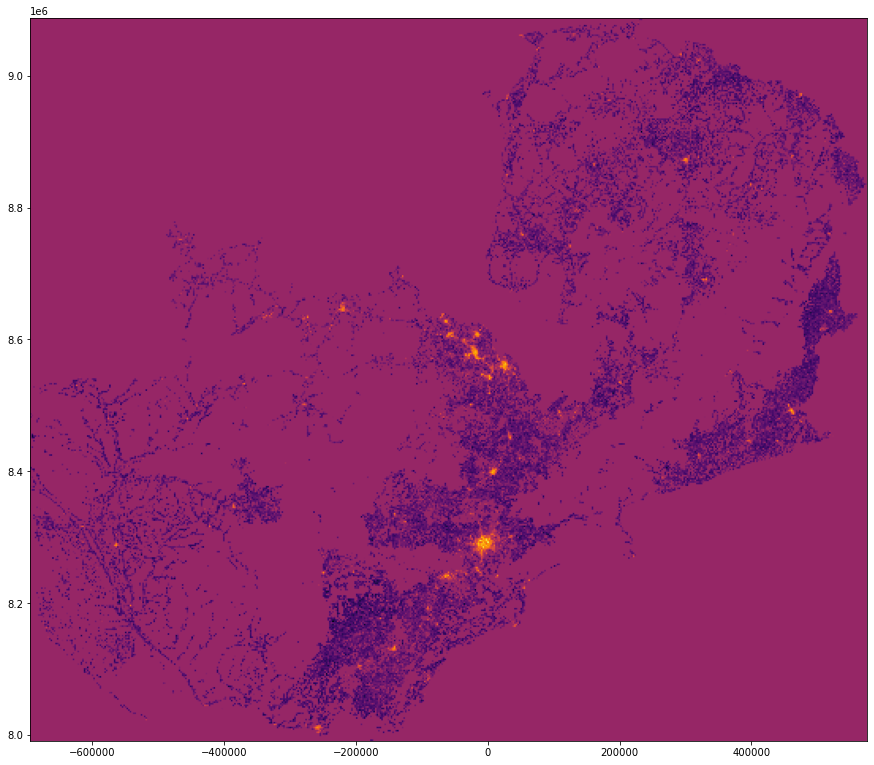

In [53]:
src = rasterio.open(out_path + '\\' + out_raster_name)

# getting extent from bounds fro proper vizualization
src_extent = np.asarray(src.bounds)[[0,2,1,3]]

plt.figure(figsize = (15,15))
plt.imshow(src.read(1), cmap='inferno', extent=src_extent)

plt.show()

In [54]:
# Define project function

def reproj(input_raster, output_raster, new_crs, factor):
    dst_crs = new_crs

    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width*factor, src.height*factor, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [55]:
## Set inout directories
out_path + '\\' + out_raster_name

# Provide the input raster and give a name to the output (reprojected) raster
input_raster = out_path + "\\" + out_raster_name
output_raster = out_path + "\\" + out_raster_name_crs

# Set target CRS
new_crs = "epsg:4326"

# Provide a factor if you want zoomed in/out results; suggest keeping it to one unless fully understanding the implications
factor = 1

In [56]:
# Run function 
reproj(input_raster, output_raster, new_crs, factor)